In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend, find_peaks
from scipy.fft import fft, fftfreq

module_path = os.path.abspath(os.path.join('..', 'src', 'zf_track_analysis'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from src.zf_track_analysis.utils import compute_derivative, get_body_center
from src.zf_track_analysis.utils import compute_base_and_heading, compute_turn_angles
from src.zf_track_analysis.utils import compute_tail_curvature_metrics
from src.zf_track_analysis.utils import quick_smooth, find_repeats, process_bout_overlaps

In [3]:
dlc_df = pd.read_hdf(r'..\demo_dlc_output.h5')
scorer = dlc_df.columns.get_level_values(0)[0]

FPS = 300

In [4]:
def get_point_metrics(dataframe : pd.DataFrame,
                      bodypart : str,
                      mask=None,
                      px_tolerances=(0.0, 1000),
                      movavg=None,
                      **kwargs) -> pd.DataFrame:
    """ Computes point-based metrics from a pd.DataFrame with a dlc result structure.  
        Calcualates normalized x and y positions, distance from image center (for square videos),
         distance travelled, speeds and acceleration.
        Variable names: 
            'x', 'y', 'x_norm', 'y_norm', 'likelihood', 'dist_travelled',
            'velocity', 'acceleration', 'dist_to_center'
        additional variables (if 'movavg' is in kwargs)
            'x_smooth', 'y_smooth', 'x_norm_smooth', 'y_norm_smooth',
            'dist_travelled_smooth', 'velocity_smooth', 'acceleration_smooth',
            'dist_to_center_smooth'
    Args:
        dataframe (pd.DataFrame): dataframe in the same structure of a dlc output from h5/csv file.
        bodypart (str): str with the name of the body part in the dataframe to be used to compute 
            the point metrics. after getting body center, we tend to use 'mean_body_keypoint' but 
            you can use an existing keypoint if you prefer (e.g. 'swim_bladder')
        mask (np.ndarray): a boolean mask that will filter out unwanted datapoints. 
        px_tol (tuple): two-element tuple with a low and high distance travelled (in pixels) 
            tolerance. Values lower than the first element and values higher than the second
            element, will be set to zero. 
    kwargs:
        'resolution' (float) : resolution in mm per pixel of the video that originated the dlc
            result file. 
        'frame_size' (int): width/height of the video frames (currently this calculation is only
            meaningful for square videos width=height)
        'fps' (int): framerate of the video that originated the dlc result file
        'movavg' (int): window size (in frames) to compue smoothed coordinates 
    Returns:
        pd.DataFrame : result dataframe with all the point metrics
    """

    ### I think it may make sense to change the output of this function to be a dictionary
    scorer = dataframe.columns.get_level_values(0)[0]

    # Process kwargs
    if 'resolution' in kwargs:
        RESOLUTION = kwargs['resolution']
    else:
        Warning('Image resolution not given, distance and velocity results will be in px')
        RESOLUTION = 1.0

    if 'frame_size' in kwargs:
        if kwargs['frame_size'] is not None:
            FRAME_SIZE = kwargs['frame_size']
        else:
            Warning("""Frame size (px) is None, point coordinate will not be 
                     and distance to center calculations will be incorrect""")
            FRAME_SIZE = 1.0
    else:
        Warning("""Frame size (px) not given, point coordinate will not be normalized
                and distance to center calculations will be incorrect""")
        FRAME_SIZE = 1.0

    if 'fps' in kwargs:
        if kwargs['fps'] is not None:
            FPS = kwargs['fps']
        else:
            Warning('FPS is none. Velocity calculations will be computed using dt = 1 s')
            FPS = 1.0
    else:
        Warning('FPS was not given. Velocity calculations will be computed using dt = 1 s')
        FPS = 1.0

    # but are also incorrectly detected to be in (0,0) point in the video
    # thus, it is necessary to remove those
    if mask is None:
        # just find points that are not (0,0) 
        mask = np.all(dataframe[scorer][bodypart][['x', 'y']].values != 0, axis=1)
    else:
        non_zero_rows = np.all(dataframe[scorer][bodypart][['x', 'y']].values != 0, axis=1)
        mask = np.logical_and(mask, non_zero_rows)

    # note for the future: As of now, moving average does not take into account whether the
    # points are from consecutive frames or not, if many datapoints are lost due to incorrect 
    # dlc detection (e.g. point (0,0) but high likelihood). this may be an issue
    # as the moving averages will show considerable movement but the fish really isnt moving it 
    # may be good to implement a moving average for chunks of consecutive frames

    # now, the result will have the same size (number of data points)
    # as the dlc output, but the filtered points will be populated with nans
    n_time_pts = len(dataframe)
    frames = np.arange(n_time_pts)
    times = frames*(1/FPS)
    time_array = np.full((n_time_pts,2), np.nan)
    time_array[mask, 0] = frames[mask]
    time_array[mask, 1] = times[mask]

    coords = np.full(dataframe[scorer][bodypart][['x', 'y']].values.shape, np.nan)
    coords[mask, :] = dataframe[scorer][bodypart][['x', 'y']].values[mask]

    likelihood = np.full(dataframe[scorer][bodypart]['likelihood'].values.shape, np.nan)
    likelihood[mask] = dataframe[scorer][bodypart]['likelihood'].values[mask]

    # CREATE THE SAME STUFF WITH NANS FOR THE RESULTS
    dist = np.full((time_array.shape[0], ), np.nan)
    velocities = np.full((time_array.shape[0], ), np.nan)
    acceleration = np.full((time_array.shape[0], ), np.nan)
    coords_norm = np.full((time_array.shape[0],2), np.nan)
    dist_to_center = np.full((time_array.shape[0], ), np.nan)

    # Clean dist and velocities using the px_tol which are to minimize flickering in in the low end
    # and incorrect detection of keypoints due to artifacts in the frame in the high end
    x_diff = compute_derivative(coords[mask, 0])
    y_diff = compute_derivative(coords[mask, 1])
    dist[mask] = np.sqrt(x_diff**2 + y_diff**2)
    dist[dist < px_tolerances[0]] = 0.0
    dist[dist > px_tolerances[1]] = 0.0
    dist = dist * RESOLUTION

    # calculate velocities and acceleration
    v_x = compute_derivative(coords[mask, 0], x=time_array[mask,1])
    v_y = compute_derivative(coords[mask, 1], x=time_array[mask,1])
    velocities[mask] = np.sqrt(v_x**2 + v_y**2)
    velocities = velocities * RESOLUTION
    acceleration[mask] = compute_derivative(velocities[mask], x=time_array[mask,1])

    # calulate the normalized coordinates with 0,0 being the center
    # of the frame, -1, 1 being edges of the frame
    # which are always approximately the edge of the circular well (+- 1 mm)
    #coords_norm = (coords - (FRAME_SIZE/2))/ (FRAME_SIZE/2)
    coords_norm[mask, :] = (coords[mask, :] - (FRAME_SIZE/2))/ (FRAME_SIZE/2)

    diff_to_center = coords[mask, :] - np.array([(FRAME_SIZE/2), (FRAME_SIZE/2)])
    dist_to_center[mask] = np.sqrt(np.sum(diff_to_center**2, axis=1)) * RESOLUTION

    # define column names
    row_1 = ['Frame',
             'Time',
             bodypart,
             bodypart,
             bodypart,
             bodypart,
             bodypart,
             bodypart,
             bodypart,
             bodypart,
             bodypart]
    row_2 = ['Frame',
             'Time',
             'x',
             'y',
             'x_norm',
             'y_norm',
             'likelihood',
             'dist_travelled',
             'velocity',
             'acceleration',
             'dist_to_center']

    if movavg is not None:

        coords_smooth = np.full(dataframe[scorer][bodypart][['x', 'y']].values.shape, np.nan)
        coords_smooth[mask, :] = dataframe[scorer][bodypart][['x', 'y']].values[mask]

        if (movavg % 2) == 0:
            temp_coords = np.vstack((np.repeat(coords_smooth[mask,:][0].reshape(1,2),
                                               int((movavg-1)/2), axis=0),
                                               coords_smooth[mask,:],
                                     np.repeat(coords_smooth[mask,:][-1].reshape(1,2),
                                               int(movavg/2), axis=0)))
        if (movavg % 2) == 1:
            temp_coords = np.vstack((np.repeat(coords_smooth[mask,:][0].reshape(1,2),
                                               int(movavg/2), axis=0),
                                               coords_smooth[mask,:],
                                     np.repeat(coords_smooth[mask,:][-1].reshape(1,2),
                                               int(movavg/2), axis=0)))

        x_coords = np.convolve(temp_coords[:,0], np.ones(movavg),
                               mode='valid') / movavg
        y_coords = np.convolve(temp_coords[:,1], np.ones(movavg),
                               mode='valid') / movavg
        coords_smooth[mask, :] = np.column_stack((x_coords, y_coords))

        #same block of calculations done with the smoothed coordinates
        dist_smooth =  np.full((time_array.shape[0],), np.nan)
        velocities_smooth =  np.full((time_array.shape[0], ), np.nan)
        acceleration_smooth =  np.full((time_array.shape[0], ), np.nan)
        coords_norm_smooth = np.full((time_array.shape[0], 2), np.nan)
        dist_to_center_smooth =  np.full((time_array.shape[0], ), np.nan)

        x_smooth_diff = compute_derivative(coords_smooth[mask, 0])
        y_smooth_diff = compute_derivative(coords_smooth[mask, 1])
        dist_smooth[mask] = np.sqrt(x_smooth_diff**2 + y_smooth_diff**2)
        dist_smooth[dist_smooth < px_tolerances[0]] = 0.0
        dist_smooth[dist_smooth > px_tolerances[1]] = 0.0
        dist_smooth = dist_smooth * RESOLUTION

        # calculate velocities and acceleration
        v_x = compute_derivative(coords_smooth[mask, 0], x=time_array[mask,1])
        v_y = compute_derivative(coords_smooth[mask, 1], x=time_array[mask,1])
        velocities_smooth[mask] = np.sqrt(v_x**2 + v_y**2)
        velocities_smooth = velocities_smooth * RESOLUTION
        acceleration_smooth[mask] = compute_derivative(velocities_smooth[mask],
                                                       x=time_array[mask,1])

        coords_norm_smooth[mask, :] = (coords_smooth[mask, :] - (FRAME_SIZE/2))/ (FRAME_SIZE/2)
        diff_to_center_smooth = coords_smooth[mask, :] - np.array([(FRAME_SIZE/2), (FRAME_SIZE/2)])
        dist_to_center_smooth[mask] = np.sqrt(np.sum(diff_to_center_smooth**2, axis=1)) * RESOLUTION

        # define column names
        row_1.extend([bodypart]*8)
        row_2.extend(['x_smooth',
                      'y_smooth',
                      'x_norm_smooth',
                      'y_norm_smooth',
                      'dist_travelled_smooth',
                      'velocity_smooth',
                      'acceleration_smooth',
                      'dist_to_center_smooth'])

    results_structure = [row_1,
                         row_2]
    tuples = list(zip(*results_structure))
    results_structure = pd.MultiIndex.from_tuples(tuples)
    df = pd.DataFrame(columns=results_structure)

    df[[('Frame', 'Frame'), ('Time', 'Time')]] = time_array
    df[bodypart,'x'] = coords[:, 0]
    df[bodypart,'y'] = coords[:, 1]
    df[bodypart,'x_norm'] = coords_norm[:,0]
    df[bodypart,'y_norm'] = coords_norm[:,1]

    df[bodypart,'likelihood'] = likelihood
    df[bodypart,'dist_travelled'] = dist
    df[bodypart,'velocity'] = velocities
    df[bodypart,'acceleration'] = acceleration
    df[bodypart,'dist_to_center'] = dist_to_center

    if movavg is not None:
        df[bodypart, 'x_smooth'] = coords_smooth[:, 0]
        df[bodypart, 'y_smooth'] = coords_smooth[:, 1]
        df[bodypart, 'x_norm_smooth'] = coords_norm_smooth[:, 0]
        df[bodypart, 'y_norm_smooth'] = coords_norm_smooth[:, 1]
        df[bodypart, 'dist_travelled_smooth'] = dist_smooth
        df[bodypart, 'velocity_smooth'] = velocities_smooth
        df[bodypart, 'acceleration_smooth'] = acceleration_smooth
        df[bodypart, 'dist_to_center_smooth'] = dist_to_center_smooth

    return df

def get_vector_metrics(dataframe: pd.DataFrame, keypoints_to_vectors : list, mask=None, **kwargs):
    """ Compute all vector-based metrics 

    Args:
        dataframe ([type]): [description]
        keypoints_to_vectors (tuple): two-element tuple with lists of 
            str ontaining the two points to define the animal's heading.
            e.g. (['swim_bladder'], ['L_eye_top', 'R_eye_top', 'L_eye_bottom', 'R_eye_bottom'])
            the first set of keypoints determines the origin of the heading vector, and the second 
            set defines the its 'tip'.

    kwargs:
        'truncate' (int) : calculate vector metrics using fewer tail points by setting truncate 
            value to a number lower than 10 (10 is the total number of tail points). 
        'fps' (int): framerate of the video that originated the dlc result file
        'smooth' (int): window size, in frames (smooth > 3), with which to smooth the tail segment
            angle and heading angle data. Uses the savitzky-golay filter (polyorder=3). 
            This will help smooth the mean tail curvature metrics (mtc, mtc_velocity, mtc_accel)
    Returns:
        pd.DataFrame: full dataframe with the vector metrics results
    """

    ### I think it may make sense to change the output of this function to be a dictionary
    origin, point = keypoints_to_vectors

    scorer = dataframe.columns.get_level_values(0)[0]

    if 'truncate' in kwargs:
        TRUNCATE_TAIL_SEGS = kwargs['truncate']
    else: 
        TRUNCATE_TAIL_SEGS = 10

    if 'fps' in kwargs:
        if kwargs['fps'] is not None:
            FPS = kwargs['fps']
        else: 
            Warning('FPS is None. Velocity calculations will be computed using dt = 1 s')
            FPS = 1.0
    else:
        Warning('FPS was not given. Velocity calculations will be computed using dt = 1 s')
        FPS = 1.0

    if 'smooth' in kwargs:
        SMOOTH = kwargs['smooth']
    else: 
        SMOOTH = None

    N_TIME_PTS = len(dataframe)
    if mask is None:
        mask = np.full((N_TIME_PTS,), 1).astype(bool)

    frames = np.arange(N_TIME_PTS).reshape((-1,1))
    times = frames*(1/FPS)
    time_array = np.hstack([frames[mask],times[mask]]).reshape((-1,2))

    df = compute_base_and_heading(dataframe,
                                  time_array,
                                  origin,
                                  point,
                                  truncate=TRUNCATE_TAIL_SEGS,
                                  smooth=SMOOTH)
    df = compute_turn_angles(df, time_array=time_array)

    # add new columns to df so it later receives the outputs from compute_tail_curvature_metrics()
    results_structure = [[],[]]
    for i in range(1,TRUNCATE_TAIL_SEGS+1):
        results_structure[0].extend(['tail_vector_' + str(i), 'tail_vector_' + str(i)])
    for i in range(1,TRUNCATE_TAIL_SEGS+1):
        results_structure[0].extend(['tail_angle_' + str(i)])

    results_structure[1].extend(['x', 'y'] * TRUNCATE_TAIL_SEGS)
    results_structure[1].extend(['angle'] * TRUNCATE_TAIL_SEGS)
    results_structure[0].extend(['mtc', 'mtc_velocity', 'mtc_accel'])
    results_structure[1].extend(['mtc', 'mtc_velocity', 'mtc_accel'])
    tuples = list(zip(*results_structure))

    for column in tuples:
        df[column] = np.nan

    # prepare inputs for compute_tail_curvature_metrics()
    heading_vector = df.iloc[:,4:6].values
    tail_list = []

    for coord in ['x', 'y']:
        tail_list.append(('swim_bladder', coord))
    for i in range(1,TRUNCATE_TAIL_SEGS+1):
        for coord in ['x', 'y']:
            tail_list.append(('tail_'+str(i), coord))

    mtc_metrics = compute_tail_curvature_metrics(heading_vector,
                                                 time_array,
                                                 dataframe[scorer][tail_list].values,
                                                 truncate=TRUNCATE_TAIL_SEGS,
                                                 smooth=SMOOTH)

    for key, values in mtc_metrics.items():
        df[key] = values

    return df

def get_all_metrics(dataframe : pd.DataFrame,
                    exp_metadata: dict,
                    bodyparts_dict: dict,
                    pcutoff=0.8,
                    mask=None,
                    px_tolerances=(0,1000),
                    **kwargs) -> pd.DataFrame:

    """ Computes all point- and vector-based metrics from a dlc output dataframe

    Args:
        dataframe (pd.DataFrame): _description_
        exp_metadata (_type_): _description_
        bodyparts_dict (_type_): _description_
        pcutoff (float, optional): _description_. Defaults to 0.8.
        mask (np.ndarray, bool, optional): mask to filter particular time interval of the 
            dlc dataframe. Has to have the same length as the dataframe (len(mask)==len(dataframe)).
            Defaults to None.
        px_tolerances (tuple, optional): _description_. Defaults to (0,1000).

    kwargs: 
        'point_movavg': window size (in frames) to compue smoothed coordinates using a
             moving average. 
        'vector_smooth': window size, in frames (vector_smooth > 3), with which to smooth the tail 
            segment angle data. Uses the savitzky-golay filter (polyorder=3). 
            This will help smooth the mean tail curvature metrics (mtc, mtc_velocity, mtc_accel)
        'truncate_tail_pts': calculate vector metrics using fewer tail points by trunacting the 
            number of tail points (10 is the total number of tail points). 

    Raises:
        TypeError: _description_

    Returns:
        pd.DataFrame: _description_
    """
    # process kwargs
    if 'point_movavg' in kwargs:
        MOVAVG = kwargs['point_movavg']
    else:
        MOVAVG = None

    if 'vector_smooth' in kwargs:
        SMOOTH = kwargs['vector_smooth']
    else:
        SMOOTH = None
    
    if 'truncate_tail_pts' in kwargs:
        TRUNCATE = kwargs['truncate_tail_pts']
    else:
        TRUNCATE = 10

    # store metadata 
    if isinstance(exp_metadata, dict):
        RESOLUTION = exp_metadata['experiment_specs']['resolution_mmpx']
        FPS = int(exp_metadata['camera_specs']['frame_rate'])
        FRAME_SIZE = int(exp_metadata['camera_specs']['width'])
    else:
        raise TypeError("""exp_metadata not type dict. This new version of the function takes
                        exp_metadata as dictionary.""")

    N_TIME_PTS = len(dataframe)
    if mask is not None:
        if len(mask) != len(dataframe):
            raise ValueError("mask has to have the same length as dataframe")
    if mask is None:
        mask = np.full((N_TIME_PTS,), 1).astype(bool)

    if len(bodyparts_dict['point_metrics']) > 1:
        mean_body_kpoint_df = get_body_center(dataframe[mask],
                                              bodyparts_dict['point_metrics'],
                                              pcutoff=pcutoff)

        dataframe = pd.concat([dataframe[mask], mean_body_kpoint_df], axis=1)

        point_metrics_df = get_point_metrics(dataframe,
                                             bodypart='mean_body_keypoint',
                                             mask=mask,
                                             px_tolerances=px_tolerances,
                                             resolution=RESOLUTION,
                                             frame_size=FRAME_SIZE,
                                             fps=FPS,
                                             movavg=MOVAVG)

    if len(bodyparts_dict['point_metrics']) == 1:
        point_metrics_df = get_point_metrics(dataframe[mask],
                                             bodypart=bodyparts_dict['point_metrics'],
                                             mask=mask,
                                             px_tolerances=px_tolerances,
                                             resolution=RESOLUTION,
                                             frame_size=FRAME_SIZE,
                                             fps=FPS,
                                             movavg=MOVAVG)

    vector_metrics_df = get_vector_metrics(dataframe[mask],
                                           keypoints_to_vectors=bodyparts_dict['vector_metrics'],
                                           fps=FPS,
                                           truncate=TRUNCATE,
                                           smooth=SMOOTH)

    all_metrics_df = pd.concat([point_metrics_df, vector_metrics_df], axis=1)

    # Sort the column index to prevent PerformanceWarning and improve lookup speed
    all_metrics_df.sort_index(axis=1, inplace=True)

    return all_metrics_df

def bout_detector(
    all_metrics,
    frame_rate,
    smooth_window=9,
    min_peak_separation=0.05,
    min_peak_prominence=0.01,
    bout_window_start=60,
    bout_window_end=100,
    accel_threshold=5,
    mtc_std_threshold=0.5,
    num_repeats=8,
) -> dict:
    """
    detects the onset and offset of swim bouts using the dataframe output from get_all_metrics()
    Args:
        point_metrics (dict): Dictionary containing point-based kinematic data,
                              including 'distance_mm', 'velocity', and 'acceleration'.
        vector_metrics (dict): Dictionary containing vector-based metrics, including
                               'mean_tail_vel', 'mean_tail_angle', and 'delta_heading'.
        frame_rate (int): The video frame rate in Hz.
        smooth_window (int, optional): The size of the smoothing window. Defaults to 5.
        min_peak_separation (float, optional): Minimum time in seconds between movement peaks. 
            Defaults to 0.05.
        min_peak_prominence (float, optional): Minimun prominence of a peak to be considered 
            a valid bout. Defaults to 0.01.
        bout_window_start (int, optional): Number of frames to look back from a peak to 
            find the start. Defaults to 60.
        bout_window_end (int, optional): Number of frames to look forward from a peak to
            find the end. Defaults to 100.
        accel_threhold (float, optional): body acceleration threshold to find end of the bout. 
            Defaults to 5.
        mtc_std_threshold (float, optional): mean tail curvature standard deviation threshold 
            to find end of the bout. Defaults to 0.5.
        num_repeats (int, optional): Number of consecutive frames of low/zero movement to 
            define start/end. Defaults to 7.


    Returns:
        dict: A dictionary containing various metrics for each detected bout.
    """
    # Get main keypoint name
    print(all_metrics.columns.get_level_values(0))
    keypt_name = all_metrics.columns.get_level_values(0)[5]
    # Grab point metrics
    distance_mm = all_metrics[(keypt_name, 'dist_travelled')].values
    acceleration = all_metrics[(keypt_name, 'acceleration')].values

    # Locate the bouts
    distance_mm_smoothed = quick_smooth(distance_mm, smooth_window)
    acceleration_smoothed = quick_smooth(acceleration, smooth_window)

    peaks, _ = find_peaks(distance_mm_smoothed,
                          distance=min_peak_separation * frame_rate,
                          prominence=min_peak_prominence)

    # Adjust peak locations to account for smoothing window
    locs = peaks + (smooth_window - 1) // 2

    # 3. Filter bouts
    # Remove bouts too close to start/end
    valid_indices = (locs > bout_window_start) & (locs + bout_window_end < len(distance_mm))
    trimmed_locs = locs[valid_indices]

    # Remove bouts with bad tracking (too many NaNs)
    bad_bouts = []
    for i, loc in enumerate(trimmed_locs):
        start_win = loc - bout_window_start
        end_win_start = loc + bout_window_end

        window_before = distance_mm[start_win:loc]
        window_after = distance_mm[loc:end_win_start]

        nan_ratio_before = np.sum(np.isnan(window_before)) / len(window_before)
        nan_ratio_after = np.sum(np.isnan(window_after)) / len(window_after)

        if nan_ratio_before >= 0.5 or nan_ratio_after >= 0.5:
            bad_bouts.append(i)

    trimmed_locs = np.delete(trimmed_locs, bad_bouts)

    # 4. Determine bout start
    bout_start_locs = []
    for loc in trimmed_locs:
        window_of_interest = distance_mm_smoothed[(loc - bout_window_start):loc]
        # To handle NaNs pythonically, we create a temporary version of the
        # window where NaNs are replaced with a value that won't affect logic (e.g., infinity).
        # This avoids modifying the original data with a "magic number".
        window_for_repeats = np.nan_to_num(window_of_interest, nan=np.inf)
        repeat_array = find_repeats(window_for_repeats)

        # Find last sequence of repeats or zero movement
        # The condition for `window_of_interest == 0` is checked on the original data.
        start_candidates = np.where((repeat_array >= num_repeats) & (window_of_interest == 0))[0]
        if start_candidates.size > 0:
            start_temp = (loc - bout_window_start) + np.max(start_candidates)
        else: # If not found, use max change in acceleration
            accel_change = acceleration_smoothed[(loc - bout_window_start):loc]
            max_i = np.argmax(accel_change) if accel_change.size > 0 else 0
            start_temp = (loc - bout_window_start) + max_i
        bout_start_locs.append(start_temp)

    bout_start_locs = np.array(bout_start_locs)

    # Filter out bouts where start is after peak
    valid_indices = (trimmed_locs - bout_start_locs) > 0
    trimmed_locs = trimmed_locs[valid_indices]
    bout_start_locs = bout_start_locs[valid_indices]

    # 5. Determine bout end (distance-based)
    bout_end_locs = []
    for i, loc in enumerate(trimmed_locs):
        # Strategy from `find_end` function
        window_of_interest = distance_mm_smoothed[loc:(loc + bout_window_end)].copy()

        # we divide acceleration by 10k, mtd_std by 100 to put them in the same order of magnitude
        # this is not necessary if you do not want to see the data in the same plot
        window_accel = np.absolute(acceleration_smoothed[loc:(loc + bout_window_end)])/10000
        window_mtc_std = all_metrics[('mtc', 'mtc')][loc:(loc + bout_window_end)] \
            .rolling(smooth_window).std()/100
        window_mtc_std = window_mtc_std.values.reshape((-1,))

        end_found = False
        # Iteratively search for minimum that meets criteria
        for _ in range(int(bout_window_end)):
            min_idx = np.nanargmin(window_of_interest)

            if np.logical_and(window_accel[min_idx] <= accel_threshold/10000,
                              window_mtc_std[min_idx] <= mtc_std_threshold/100):
                end_temp = loc + (min_idx if min_idx >= 5 else 5)
                end_found = True
                break
            else:
                window_of_interest[min_idx] = np.inf # Mark as checked and find next minimum
        if not end_found: # Fallback if no point meets the criteria

            end_temp = loc + np.nanargmin(distance_mm_smoothed[loc:(loc + bout_window_end)])

        bout_end_locs.append(end_temp)
    bout_end_locs = np.array(bout_end_locs)

    # remove or merge overlapped bouts
    bout_metric = process_bout_overlaps({'onset': bout_start_locs, 'offset':bout_end_locs})

    return bout_metric

def compute_single_bout_metrics(all_metrics_df:pd.DataFrame,
                         onset_offset:tuple,
                         FPS=1,
                         smooth_point=None,
                         smooth_vector= None,
                         smooth_vigor_window=43) -> dict:
    
    """ computes bout metrics of a single bout.

    Args:
        all_metrics_df (pd.DataFrame): frame-by-frame kinematic data (output from get_all_metrics)
        onset_offset (tuple): tuple where first and second elements comprise of bout 
            onset and offset, respectively.
        FPS (int, optional): recording framerate (in Hz). Defaults to 1.
        smooth_point (tuple, optional): parameters to smooth point metrics. First element
            is a string (at the moment only 'mean' is an option), second element is the time window
            in miliseconds to run the moving average with. Defaults to None.
        smooth_vector (tuple, optional): parameters to smooth vector metrics. First element
            is a string (at the moment only 'mean' is an option), second element is the time window
            in miliseconds to run the moving average ('mean') with. Defaults to None.
        smooth_vigor_window (int, optional): time window in miliseconds to run the vigor calculation
            with a moving average. Defaults to 43 ms.

    Returns:
        dict: bout metrics with keys as metrics names, values are their values.
    """

    # Get main keypoint name
    keypt_name = all_metrics_df.columns.get_level_values(0)[5]

    if smooth_point[0] == 'mean':
        window = int(smooth_point[1] / (1000*(1/FPS)))
        dt_values = quick_smooth(all_metrics_df[(keypt_name, 'dist_travelled')].values,
                                  smooth_val=window)
        velocity = quick_smooth(all_metrics_df[(keypt_name, 'velocity')].values,
                                 smooth_val=window)
        acceleration = quick_smooth(all_metrics_df[(keypt_name, 'acceleration')].values,
                                     smooth_val=window)

    if smooth_point is None:
        dt_values = all_metrics_df[(keypt_name, 'dist_travelled')]
        velocity = all_metrics_df[(keypt_name, 'velocity')]
        acceleration = all_metrics_df[(keypt_name, 'acceleration')]

    if smooth_vector[0] == 'mean':
        window = int(smooth_vector[1] / (1000*(1/FPS)))
        mtc = all_metrics_df[('mtc', 'mtc')].rolling(window).mean().values.reshape((-1,))
        mtc_velocity = all_metrics_df[('mtc_velocity', 'mtc_velocity')] \
            .rolling(window).mean().values.reshape((-1,))
        turn_angles =  all_metrics_df[('turn_angles', 'turn_angles')] \
            .rolling(window).mean().values.reshape((-1,))
        heading = all_metrics_df[('heading_degrees', 'heading_degrees')] \
            .rolling(window).mean().values.reshape((-1,))

    if smooth_vector is None:
        mtc = all_metrics_df[('mtc', 'mtc')].values.reshape((-1,))
        mtc_velocity = all_metrics_df[('mtc_velocity', 'mtc_velocity')].values.reshape((-1,))
        turn_angles =  all_metrics_df[('turn_angles', 'turn_angles')].values.reshape((-1,))
        heading = all_metrics_df[('heading_degrees', 'heading_degrees')].values.reshape((-1,))

    onset = onset_offset[0]
    offset = onset_offset[1]

    # HERE THE COMPUTATIONS START
    # compute bout duration in miliseconds
    duration = all_metrics_df.iloc[offset, 1] - all_metrics_df.iloc[onset, 1]
    duration = duration * 1000

    # whole-body displacement related (point-based metrics)
    total_distance = np.nansum(dt_values[onset:offset])
    average_speed = total_distance / (duration/1000)
    max_point_speed = np.nanmax(velocity[onset:offset])
    max_point_accel = np.nanmax(acceleration[onset:offset])

    # tail related (vector-based)
    mean_mtc = np.nanmean(mtc[onset:offset])
    max_point_mtc = np.nanmax(mtc[onset:offset])
    min_point_mtc = np.nanmin(mtc[onset:offset])
    max_abs_point_mtc = np.nanmax(np.abs(mtc[onset:offset]))
    bout_symmetry = (max_point_mtc + min_point_mtc) / (max_point_mtc - min_point_mtc)

    max_mtc_velocity = np.nanmax(mtc_velocity[onset:offset])
    mean_mtc_velocity = np.nanmean(np.abs(mtc_velocity[onset:offset]))

    tail_beat_fft = fft(detrend(mtc[onset:offset]), n=300)
    frequencies = fftfreq(300, 1/FPS)
    pos_freq_mask = frequencies > 0
    dominant_tailbeat_freq = frequencies[np.argmax(np.abs(tail_beat_fft[pos_freq_mask])**2)]

    # tail segment related (vector-based)
    tail_angle_names = [var for var in all_metrics_df.columns.get_level_values(0) \
                        if 'tail_angle_' in var]
    columns = zip(tail_angle_names, ['angle']*(len(tail_angle_names)))
    tail_max_amplitude = np.max(np.abs(all_metrics_df[columns].values[onset:offset]), axis=0)

    # vigor related
    # vigor degrees/s
    total_vigor = np.sum(np.abs(np.diff(mtc_velocity[onset:offset], prepend=0)))
    # max vigor calculated by finding the maximum instantaneous vigor using a window
    window = int(smooth_vigor_window / (1000*(1/FPS)))
    moving_vigor = quick_smooth(np.abs(np.diff(mtc_velocity[onset:offset])), smooth_val=window)
    max_point_vigor = np.nanmax(moving_vigor)
    mean_vigor = np.nanmean(moving_vigor)

    #heading related (vector-based)
    max_turn_angle = np.max(np.abs(turn_angles[onset:offset]))
    bout_end_angle = np.abs(heading[onset]  \
                            - heading[offset])
    bout_end_angle2 = 360 - bout_end_angle 
    bout_end_angle = np.min([bout_end_angle, bout_end_angle2], axis=0)

    bout_dict = {'onset': onset_offset[0],
                 'offset': onset_offset[1],
                 'onset_s': onset_offset[0]/FPS,
                 'offset_s': onset_offset[1]/FPS}
    
    bout_dict.update({'duration': duration,                         # in miliseconts
                      'total_distance': total_distance,             # in milimeters
                      'avg_speed': average_speed,                   # in mm.s^-1
                      'max_speed': max_point_speed,                 # in mm.s^-1
                      'max_acceleration': max_point_accel,          # in mm.s^-2
                      'avg_mtc': mean_mtc,                          # in degrees
                      'max_abs_mtc': max_abs_point_mtc,             # in degrees
                      'bout_symmetry': bout_symmetry,               # dimensionless 
                      'max_mtc_velocity': max_mtc_velocity,         # in degrees.s^-1
                      'avg_mtc_velocity': mean_mtc_velocity,        # in degrees.s^-1
                      'tailbeat_frequency': dominant_tailbeat_freq, # in Hz, dominant tailbeat freq
                      'total_vigor': total_vigor,                   # in degrees.s^-1
                      'max_vigor': max_point_vigor,                 # in degrees.s^-1
                      'avg_vigor': mean_vigor,                      # in degrees.s^-1
                      'max_turn_angle': max_turn_angle,             # in degrees
                      'bout_end_angle': bout_end_angle 
                      })
    # add a variable for each tail segment max amplitude, in degrees (from absolute values)
    bout_dict.update({'max_tail_amplitude_'+str(i+1) : tail_max_amplitude[i] \
                       for i in range(len(tail_angle_names))})

    return bout_dict

def compute_bout_metrics(bouts_dict : dict, all_metrics_df : pd.DataFrame, FPS=1, **kwargs) -> dict:
    """
        Computes bout metrics of a set of swim bouts. 
    Args:
        bouts_dict (dict): dictionary containing the bout onset and offset indices 
            (output from bout_detector).
        all_metrics_df (pd.DataFrame): frame-by-frame kinematic data (output from get_all_metrics)

    Returns:
        dict: dictionary containing all bout metrics, easily transformed into a pd.Dataframe.
    """

    if 'smooth_point' in kwargs:
        smooth_point = kwargs['smooth_point']
    else:
        smooth_point = None

    if 'smooth_vector' in kwargs:
        smooth_vector = kwargs['smooth_vector']
    else:
        smooth_vector = None

    if 'smooth_vigor_window' in kwargs:
        smooth_vigor_window = kwargs['smooth_vigor_window']
    else:
        smooth_vigor_window = 40

    if 'end_time' in kwargs:
        end_time = kwargs['end_time']
    else:
        end_time = None  

    onsets = bouts_dict['onset']
    offsets = bouts_dict['offset']

    on_and_offsets = list(zip(onsets,offsets))
    print(on_and_offsets)
    bout_metrics = {}

    first_run = True
    for on_and_offset in on_and_offsets:
        single_bout_dict = compute_single_bout_metrics(all_metrics_df,
                                                       on_and_offset,
                                                       FPS=FPS,
                                                       smooth_point=smooth_point,
                                                       smooth_vector=smooth_vector,
                                                       smooth_vigor_window=smooth_vigor_window)
        if not first_run:
            for key, value in single_bout_dict.items():
                bout_metrics[key] = np.append(bout_metrics[key], value)
        if first_run:
            bout_metrics.update({key : np.array([value])
                                 for key, value in single_bout_dict.items()})
            first_run = False

    bout_metrics['IBI'] = compute_ibi(onsets, time_array=all_metrics_df[('Time', 'Time')].values, end_time=end_time)
    bout_metrics['bout_number'] = np.arange(1,len(onsets)+1)
    
    return bout_metrics

def compute_ibi(bout_onsets: list, time_array : np.ndarray, end_time=None) -> np.ndarray:
    """ Computes the interbout interval (IBI, i.e. time elapsed between start of current bout until
        the start of the next bout) for a set of bouts. Output unit of measure is the
        same as time_array units. 

    Args:
        bouts (list): list containing indices of where bouts start. 
        time_array (np.ndarray): time vector used to compute IBI
        end_time (_type_, optional): user-defined end time to calculate IBI of last bout.
            Since IBI is a paired measurement (the IBI of one bout depends on the existence of a 
            following swim bout), you can define a end time so the last bout has an IBI. 
            Defaults to None. None will output np.nan as the IBI of the last bout.
    
    Returns:
        np.ndarray: IBI values for each bout.
    """
    if end_time is not None:
        start_times = time_array[bout_onsets]
        start_times = np.append(start_times, end_time)
        return np.diff(start_times)
    else:
        ibi = np.diff(time_array[bout_onsets])
        ibi = np.append(ibi, np.nan)
        return ibi


## test vector-based metrics functions

In [5]:
df_smooth = get_vector_metrics(dlc_df, keypoints_to_vectors=(['swim_bladder'], ['L_eye_top', 'R_eye_top', 'L_eye_bottom', 'R_eye_bottom']), fps=300, smooth=9)
df_raw = get_vector_metrics(dlc_df, keypoints_to_vectors=(['swim_bladder'], ['L_eye_top', 'R_eye_top', 'L_eye_bottom', 'R_eye_bottom']), fps=300)

In [6]:
df_smooth

origin                   point             heading_vector            \
               x           y           x           y              x         y   
0      75.014404  146.359161   83.488384  143.560059       0.949539 -0.313649   
1      75.013344  146.395264   83.367161  143.532051       0.945979 -0.324228   
2      75.074905  146.291046   83.523695  143.440411       0.947521 -0.319695   
3      75.097618  146.285187   83.585121  143.460922       0.948848 -0.315734   
4      75.267921  146.227554   83.543354  143.493546       0.949522 -0.313700   
...          ...         ...         ...         ...            ...       ...   
1795  159.099854   34.144356  162.440899   26.295776       0.391677 -0.920103   
1796  159.094360   34.124275  162.436394   26.270771       0.391567 -0.920150   
1797  159.055817   34.152512  162.471275   26.334866       0.400350 -0.916362   
1798  159.113571   34.230087  162.473316   26.358327       0.392550 -0.919731   
1799  159.125198   34.097206  162.438686   26.236699       0.388435 -0.921476   

     heading_degrees turn_angles tail_vector_1            ... tail_angle_4  \
     heading_degrees turn_angles             x         y  ...        angle   
0         198.469146         NaN     -0.928478  0.371387  ...    12.350536   
1         198.570620    0.011162     -0.925383  0.379033  ...    10.542964   
2         198.596908   -0.004788     -0.921346  0.388743  ...    10.050035   
3         198.566823   -0.004177     -0.924241  0.381810  ...    10.513049   
4         198.499173   -0.002143     -0.926228  0.376963  ...    11.573303   
...              ...         ...           ...       ...  ...          ...   
1795      246.712224    0.002140     -0.481230  0.876594  ...    -2.967978   
1796      246.767416    0.000119     -0.478821  0.877912  ...    -3.036476   
1797      246.816593   -0.009565     -0.476031  0.879429  ...    -3.135836   
1798      246.895688    0.008496     -0.485360  0.874314  ...    -3.353388   
1799      247.040635    0.004470     -0.480334  0.877086  ...    -3.776463   

     tail_angle_5 tail_angle_6 tail_angle_7 tail_angle_8 tail_angle_9  \
            angle        angle        angle        angle        angle   
0        5.828268     1.883621    -1.175948     0.764903    -5.911925   
1        4.614353     0.780623    -1.537561    -2.420682     4.096150   
2        4.130445     0.142460    -1.811419    -2.294135     8.524149   
3        4.192549    -0.093406    -1.991367    -0.094023     8.821903   
4        4.616668     0.010490    -2.071251     2.941089     6.439244   
...           ...          ...          ...          ...          ...   
1795     1.607229   -17.485795    -4.211997    -0.588565    -8.242813   
1796     2.033335   -18.072267    -4.160513    -0.428180    -8.618993   
1797     2.114341   -18.371604    -4.129624    -0.354408    -8.761139   
1798     1.557265   -18.168547    -4.213865    -0.524300    -8.569775   
1799     0.069125   -17.247837    -4.507772    -1.094906    -7.945423   

     tail_angle_10       mtc mtc_velocity     mtc_accel  
             angle       mtc mtc_velocity     mtc_accel  
0       -13.174094 -0.146220   161.260547  13123.389373  
1        -6.815323  0.928851   248.749809  -6641.341950  
2        -4.547920  1.512112   116.984934 -34796.154665  
3        -5.209563  1.708750    16.775445 -22675.148277  
4        -7.637934  1.623949   -34.182721 -14273.506312  
...            ...       ...          ...           ...  
1795     -1.043807 -5.356086   -55.172533   6413.817547  
1796     -1.338622 -5.440093   -21.859273   5067.595032  
1797     -1.432364 -5.501814   -21.388567  -1723.234739  
1798     -1.276791 -5.582683   -33.347505     25.706059  
1799     -0.823658 -5.724131   -21.217193   1819.546833  

[1800 rows x 41 columns]

(-100.0, 100.0)

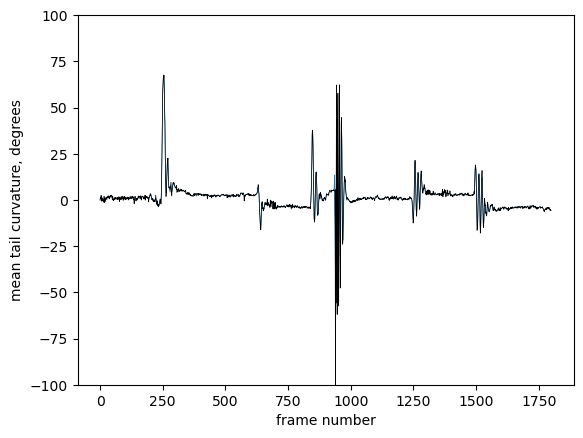

In [7]:
plt.plot(df_smooth[('mtc', 'mtc')], linewidth=0.5)
plt.plot(df_raw[('mtc', 'mtc')], linewidth=0.5, c='k')
plt.ylabel('mean tail curvature, degrees')
plt.xlabel('frame number')
plt.ylim([-100, 100])

(0.0, 500.0)

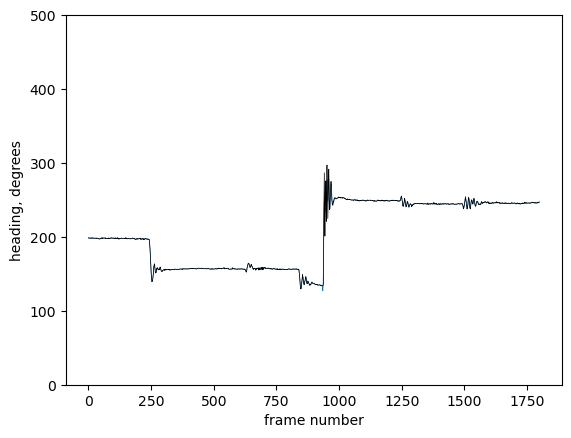

In [8]:
plt.plot(df_smooth[('heading_degrees', 'heading_degrees')], linewidth=0.5)
plt.plot(df_raw[('heading_degrees', 'heading_degrees')], linewidth=0.5, c='k')
plt.ylabel('heading, degrees')
plt.xlabel('frame number')
plt.ylim([0, 500])

### Test running each function independently

In [9]:
N_TIME_PTS = len(dlc_df)
frames = np.arange(N_TIME_PTS).reshape((-1,1)).astype(np.uint32)
times = frames*(1/FPS)
time_array = np.hstack([frames,times])

In [10]:
time_array

array([[0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 3.33333333e-03],
       [2.00000000e+00, 6.66666667e-03],
       ...,
       [1.79700000e+03, 5.99000000e+00],
       [1.79800000e+03, 5.99333333e+00],
       [1.79900000e+03, 5.99666667e+00]])

In [11]:
df = compute_base_and_heading(dlc_df, time_array, origin=['swim_bladder'], point=['L_eye_top', 'R_eye_top', 'L_eye_bottom', 'R_eye_bottom', 'swim_bladder'], truncate=10)

In [12]:
df

origin                   point             heading_vector            \
               x           y           x           y              x         y   
0      75.014404  146.359161   81.793588  144.119879       0.949539 -0.313649   
1      75.013344  146.395264   81.696397  144.104694       0.945979 -0.324228   
2      75.074905  146.291046   81.833937  144.010538       0.947521 -0.319695   
3      75.097618  146.285187   81.887621  144.025775       0.948848 -0.315734   
4      75.267921  146.227554   81.888268  144.040347       0.949522 -0.313700   
...          ...         ...         ...         ...            ...       ...   
1795  159.099854   34.144356  161.772690   27.865492       0.391677 -0.920103   
1796  159.094360   34.124275  161.767987   27.841472       0.391567 -0.920150   
1797  159.055817   34.152512  161.788184   27.898395       0.400350 -0.916362   
1798  159.113571   34.230087  161.801367   27.932679       0.392550 -0.919731   
1799  159.125198   34.097206  161.775989   27.808801       0.388435 -0.921476   

     heading_degrees  
     heading_degrees  
0         198.279287  
1         198.918794  
2         198.644480  
3         198.405154  
4         198.282343  
...              ...  
1795      246.941132  
1796      246.947978  
1797      246.399919  
1798      246.886732  
1799      247.142817  

[1800 rows x 7 columns]

In [13]:
df = compute_turn_angles(df, time_array=time_array)

In [14]:
df

origin                   point             heading_vector            \
               x           y           x           y              x         y   
0      75.014404  146.359161   81.793588  144.119879       0.949539 -0.313649   
1      75.013344  146.395264   81.696397  144.104694       0.945979 -0.324228   
2      75.074905  146.291046   81.833937  144.010538       0.947521 -0.319695   
3      75.097618  146.285187   81.887621  144.025775       0.948848 -0.315734   
4      75.267921  146.227554   81.888268  144.040347       0.949522 -0.313700   
...          ...         ...         ...         ...            ...       ...   
1795  159.099854   34.144356  161.772690   27.865492       0.391677 -0.920103   
1796  159.094360   34.124275  161.767987   27.841472       0.391567 -0.920150   
1797  159.055817   34.152512  161.788184   27.898395       0.400350 -0.916362   
1798  159.113571   34.230087  161.801367   27.932679       0.392550 -0.919731   
1799  159.125198   34.097206  161.775989   27.808801       0.388435 -0.921476   

     heading_degrees turn_angles  
     heading_degrees turn_angles  
0         198.279287         NaN  
1         198.918794    0.011162  
2         198.644480   -0.004788  
3         198.405154   -0.004177  
4         198.282343   -0.002143  
...              ...         ...  
1795      246.941132    0.002140  
1796      246.947978    0.000119  
1797      246.399919   -0.009565  
1798      246.886732    0.008496  
1799      247.142817    0.004470  

[1800 rows x 8 columns]

In [15]:
truncate = 10
# add new columns to df so it later receives the outputs from compute_tail_curvature_metrics()
results_structure = [[],[]]
for i in range(1,truncate+1):
    results_structure[0].extend(['tail_vector_' + str(i), 'tail_vector_' + str(i)])
for i in range(1,truncate+1):
    results_structure[0].extend(['tail_angle_' + str(i)])  

results_structure[1].extend(['x', 'y'] * truncate)
results_structure[1].extend(['angle'] * truncate)
results_structure[0].extend(['mtc', 'mtc_velocity', 'mtc_accel'])
results_structure[1].extend(['mtc', 'mtc_velocity', 'mtc_accel'])
tuples = list(zip(*results_structure))

for column in tuples: 
    df[column] = np.nan

In [16]:
tail_list = []

for coord in ['x', 'y']:
    tail_list.append(('swim_bladder', coord)) 
for i in range(1,10+1):
    for coord in ['x', 'y']:
        tail_list.append(('tail_'+str(i), coord))

tail_list

[('swim_bladder', 'x'),
 ('swim_bladder', 'y'),
 ('tail_1', 'x'),
 ('tail_1', 'y'),
 ('tail_2', 'x'),
 ('tail_2', 'y'),
 ('tail_3', 'x'),
 ('tail_3', 'y'),
 ('tail_4', 'x'),
 ('tail_4', 'y'),
 ('tail_5', 'x'),
 ('tail_5', 'y'),
 ('tail_6', 'x'),
 ('tail_6', 'y'),
 ('tail_7', 'x'),
 ('tail_7', 'y'),
 ('tail_8', 'x'),
 ('tail_8', 'y'),
 ('tail_9', 'x'),
 ('tail_9', 'y'),
 ('tail_10', 'x'),
 ('tail_10', 'y')]

In [17]:
mtc_metrics_smooth = compute_tail_curvature_metrics(df.iloc[:,4:6].values, time_array, dlc_df[scorer][tail_list].values, truncate=10, smooth=9)

In [18]:
for key, values in mtc_metrics_smooth.items():
    df[key] = values

In [19]:
df

origin                   point             heading_vector            \
               x           y           x           y              x         y   
0      75.014404  146.359161   81.793588  144.119879       0.949539 -0.313649   
1      75.013344  146.395264   81.696397  144.104694       0.945979 -0.324228   
2      75.074905  146.291046   81.833937  144.010538       0.947521 -0.319695   
3      75.097618  146.285187   81.887621  144.025775       0.948848 -0.315734   
4      75.267921  146.227554   81.888268  144.040347       0.949522 -0.313700   
...          ...         ...         ...         ...            ...       ...   
1795  159.099854   34.144356  161.772690   27.865492       0.391677 -0.920103   
1796  159.094360   34.124275  161.767987   27.841472       0.391567 -0.920150   
1797  159.055817   34.152512  161.788184   27.898395       0.400350 -0.916362   
1798  159.113571   34.230087  161.801367   27.932679       0.392550 -0.919731   
1799  159.125198   34.097206  161.775989   27.808801       0.388435 -0.921476   

     heading_degrees turn_angles tail_vector_1            ... tail_angle_4  \
     heading_degrees turn_angles             x         y  ...        angle   
0         198.279287         NaN     -0.928478  0.371387  ...    12.350536   
1         198.918794    0.011162     -0.925383  0.379033  ...    10.542964   
2         198.644480   -0.004788     -0.921346  0.388743  ...    10.050035   
3         198.405154   -0.004177     -0.924241  0.381810  ...    10.513049   
4         198.282343   -0.002143     -0.926228  0.376963  ...    11.573303   
...              ...         ...           ...       ...  ...          ...   
1795      246.941132    0.002140     -0.481230  0.876594  ...    -2.967978   
1796      246.947978    0.000119     -0.478821  0.877912  ...    -3.036476   
1797      246.399919   -0.009565     -0.476031  0.879429  ...    -3.135836   
1798      246.886732    0.008496     -0.485360  0.874314  ...    -3.353388   
1799      247.142817    0.004470     -0.480334  0.877086  ...    -3.776463   

     tail_angle_5 tail_angle_6 tail_angle_7 tail_angle_8 tail_angle_9  \
            angle        angle        angle        angle        angle   
0        5.828268     1.883621    -1.175948     0.764903    -5.911925   
1        4.614353     0.780623    -1.537561    -2.420682     4.096150   
2        4.130445     0.142460    -1.811419    -2.294135     8.524149   
3        4.192549    -0.093406    -1.991367    -0.094023     8.821903   
4        4.616668     0.010490    -2.071251     2.941089     6.439244   
...           ...          ...          ...          ...          ...   
1795     1.607229   -17.485795    -4.211997    -0.588565    -8.242813   
1796     2.033335   -18.072267    -4.160513    -0.428180    -8.618993   
1797     2.114341   -18.371604    -4.129624    -0.354408    -8.761139   
1798     1.557265   -18.168547    -4.213865    -0.524300    -8.569775   
1799     0.069125   -17.247837    -4.507772    -1.094906    -7.945423   

     tail_angle_10       mtc mtc_velocity     mtc_accel  
             angle       mtc mtc_velocity     mtc_accel  
0       -13.174094 -0.146220   161.260547  13123.389373  
1        -6.815323  0.928851   248.749809  -6641.341950  
2        -4.547920  1.512112   116.984934 -34796.154665  
3        -5.209563  1.708750    16.775445 -22675.148277  
4        -7.637934  1.623949   -34.182721 -14273.506312  
...            ...       ...          ...           ...  
1795     -1.043807 -5.356086   -55.172533   6413.817547  
1796     -1.338622 -5.440093   -21.859273   5067.595032  
1797     -1.432364 -5.501814   -21.388567  -1723.234739  
1798     -1.276791 -5.582683   -33.347505     25.706059  
1799     -0.823658 -5.724131   -21.217193   1819.546833  

[1800 rows x 41 columns]

(-6000.0, 6000.0)

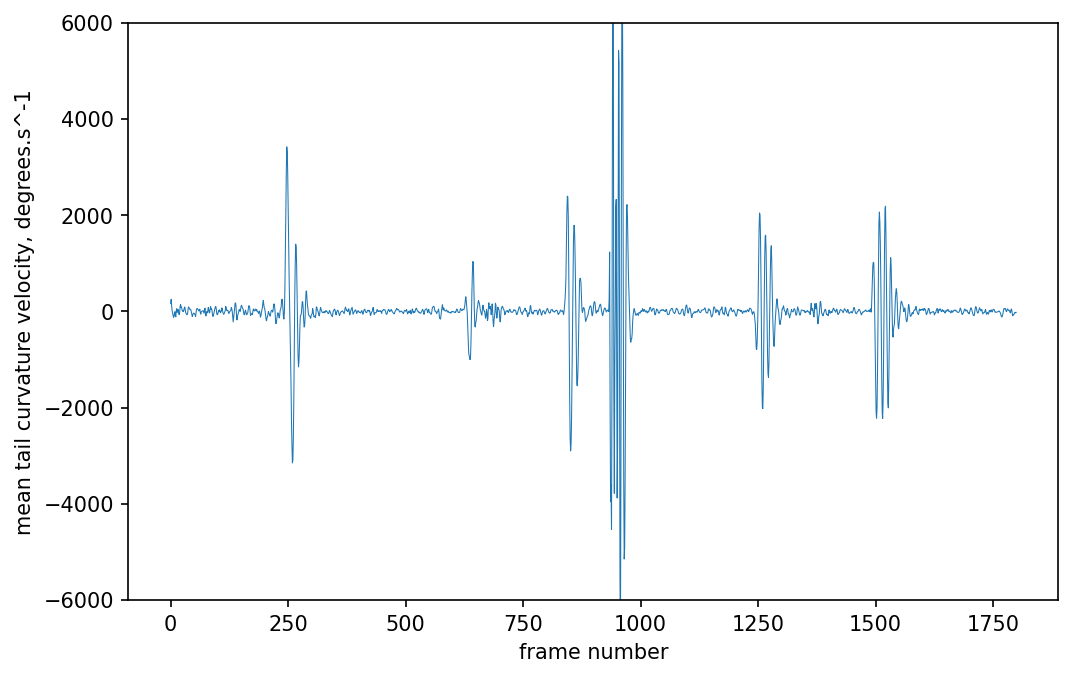

In [20]:
plt.rcParams["figure.figsize"]=(8,5)
plt.rcParams["figure.dpi"]=150
plt.plot(df[('mtc_velocity','mtc_velocity')], linewidth=0.5)
plt.xlabel('frame number')
plt.ylabel('mean tail curvature velocity, degrees.s^-1')
plt.ylim([-6000,6000])

(-600000.0, 600000.0)

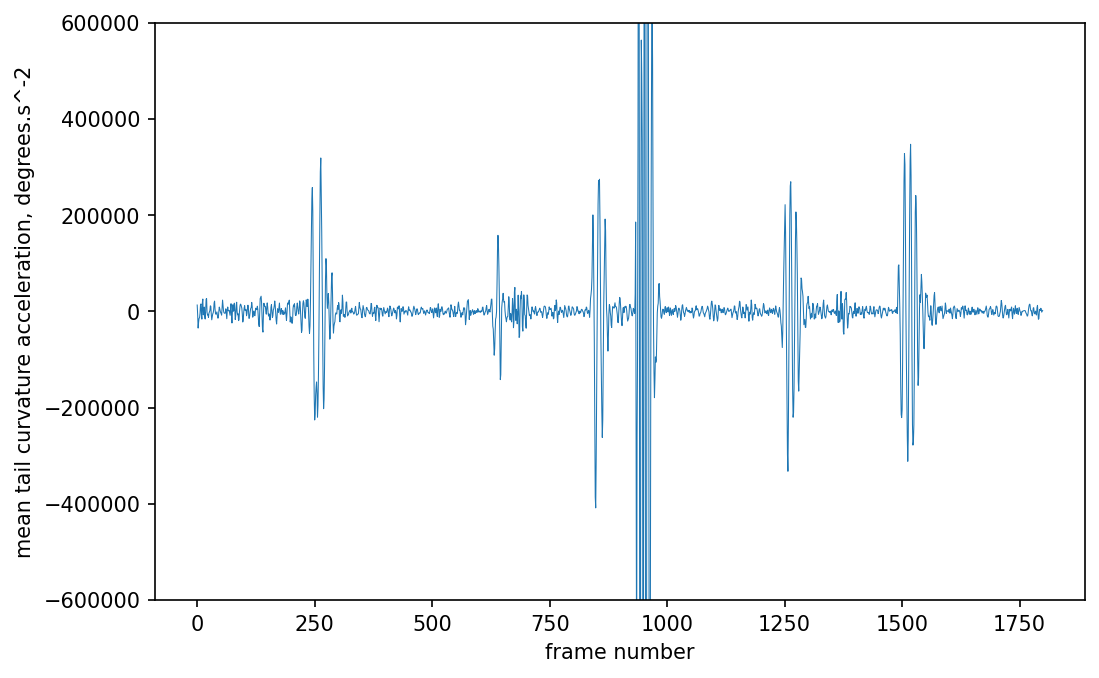

In [21]:
plt.plot(df[('mtc_accel','mtc_accel')], linewidth=0.5)
plt.ylabel('mean tail curvature acceleration, degrees.s^-2')
plt.xlabel('frame number')
plt.ylim([-600000,600000])

(-100.0, 100.0)

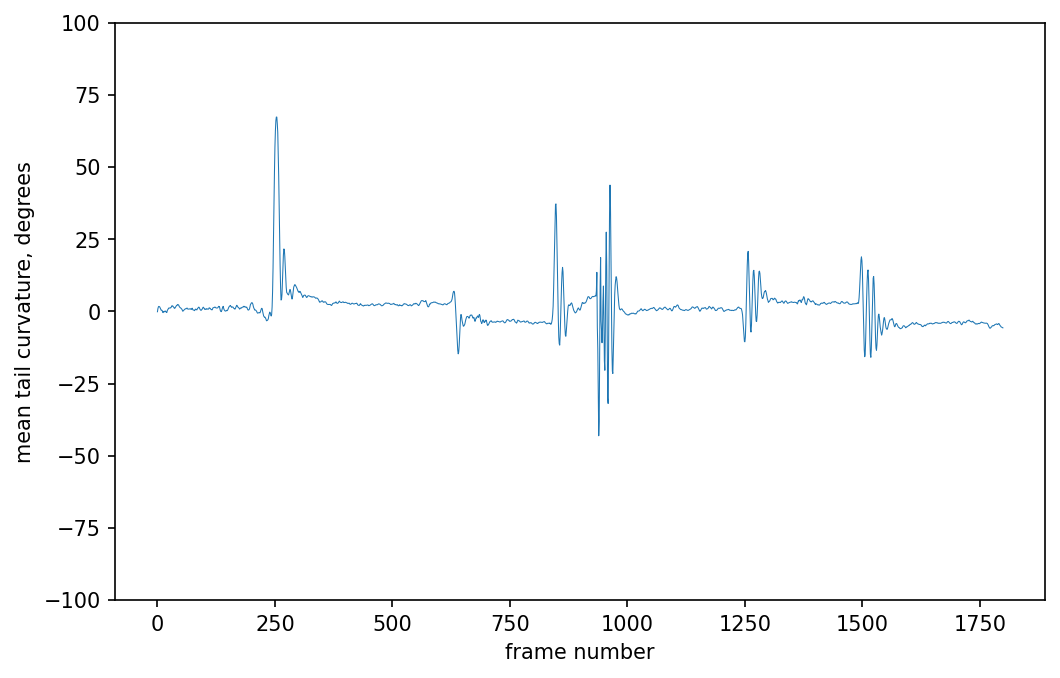

In [22]:
plt.plot(mtc_metrics_smooth[('mtc','mtc')], linewidth=0.5)
plt.ylabel('mean tail curvature, degrees')
plt.xlabel('frame number')
plt.ylim([-100,100])

try getting all metrics together


In [23]:
exp_metadata = {'experiment_specs': {'resolution_mmpx': 0.08},
                'camera_specs': {'frame_rate': 300, 
                                 'width': 254}}
bodyparts_dict = {'point_metrics': ['L_eye_top', 'R_eye_top', 'L_eye_bottom', 'R_eye_bottom', 'swim_bladder'], 
                  'vector_metrics':[['swim_bladder'],['L_eye_top', 'R_eye_top', 'L_eye_bottom', 'R_eye_bottom']]}

all_metrics = get_all_metrics(dlc_df, exp_metadata=exp_metadata, bodyparts_dict=bodyparts_dict, pcutoff=0.8, mask=None, px_tolerances=(0.15,60), point_movavg=7, vector_smooth=9, truncate_tail_pts=9)



In [24]:
all_metrics.sort_index(axis=1, inplace=True)
all_metrics


Frame      Time heading_degrees heading_vector            \
       Frame      Time heading_degrees              x         y   
0        0.0  0.000000      198.469146       0.949539 -0.313649   
1        1.0  0.003333      198.570620       0.945979 -0.324228   
2        2.0  0.006667      198.596908       0.947521 -0.319695   
3        3.0  0.010000      198.566823       0.948848 -0.315734   
4        4.0  0.013333      198.499173       0.949522 -0.313700   
...      ...       ...             ...            ...       ...   
1795  1795.0  5.983333      246.712224       0.391677 -0.920103   
1796  1796.0  5.986667      246.767416       0.391567 -0.920150   
1797  1797.0  5.990000      246.816593       0.400350 -0.916362   
1798  1798.0  5.993333      246.895688       0.392550 -0.919731   
1799  1799.0  5.996667      247.040635       0.388435 -0.921476   

     mean_body_keypoint                                     \
           acceleration acceleration_smooth dist_to_center   
0             32.721414           42.159411       3.867162   
1            195.296533           77.953080       3.874005   
2            -98.239633           58.426257       3.861052   
3           -316.264527           41.284734       3.857463   
4            146.762405          -44.705987       3.857827   
...                 ...                 ...            ...   
1795          34.978466           10.892614       8.404490   
1796          68.414617           24.331052       8.406179   
1797           0.654526           -4.904629       8.402417   
1798        -108.705308          -14.344983       8.400179   
1799         778.215711           12.826336       8.408858   

                                           ... tail_vector_5 tail_vector_6  \
     dist_to_center_smooth dist_travelled  ...             y             x   
0                 3.865880       0.000000  ...      0.412341     -0.938556   
1                 3.864547       0.000000  ...      0.388454     -0.943641   
2                 3.862830       0.000000  ...      0.395241     -0.942646   
3                 3.860223       0.000000  ...      0.383501     -0.950525   
4                 3.857790       0.000000  ...      0.392407     -0.949291   
...                    ...            ...  ...           ...           ...   
1795              8.403731       0.000000  ...      0.929298     -0.646950   
1796              8.404266       0.000000  ...      0.929646     -0.638256   
1797              8.404800       0.000000  ...      0.931593     -0.647852   
1798              8.405691       0.000000  ...      0.933247     -0.697351   
1799              8.406315       0.020232  ...      0.920193     -0.630331   

               tail_vector_7           tail_vector_8           tail_vector_9  \
             y             x         y             x         y             x   
0     0.345128     -0.953989  0.299841     -0.953492  0.301419     -0.967713   
1     0.330972     -0.957905  0.287085     -0.949003  0.315266     -0.927996   
2     0.333793     -0.957120  0.289690     -0.949990  0.312281     -0.934835   
3     0.310647     -0.957280  0.289162     -0.949483  0.313819     -0.886773   
4     0.314399     -0.959158  0.282872     -0.951576  0.307414     -0.842710   
...        ...           ...       ...           ...       ...           ...   
1795  0.762533     -0.459676  0.888086     -0.405689  0.914011     -0.524238   
1796  0.769824     -0.459370  0.888245     -0.408932  0.912565     -0.529814   
1797  0.761766     -0.459333  0.888264     -0.404260  0.914644     -0.530113   
1798  0.716730     -0.459870  0.887986     -0.386385  0.922338     -0.520785   
1799  0.776326     -0.460716  0.887547     -0.413538  0.910487     -0.515573   

               turn_angles  
             y turn_angles  
0     0.252053         NaN  
1     0.372591    0.011162  
2     0.355082   -0.004788  
3     0.462206   -0.004177  
4     0.538367   -0.002143  
...        ...         ...  
1795  0.851572    0.002140  
1796  0.848

In [25]:
dlc_df.shape

(1800, 45)

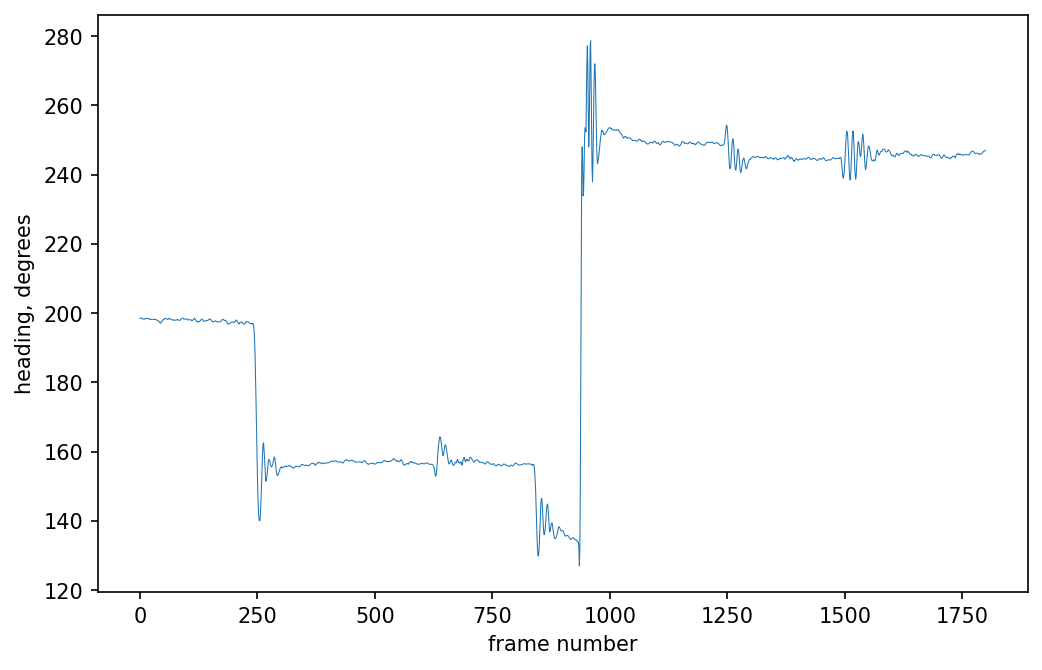

In [26]:
plt.plot(all_metrics[('heading_degrees', 'heading_degrees')], linewidth=0.5)
plt.ylabel('heading, degrees')
plt.xlabel('frame number')
plt.show()

Text(0.5, 0, 'frame number')

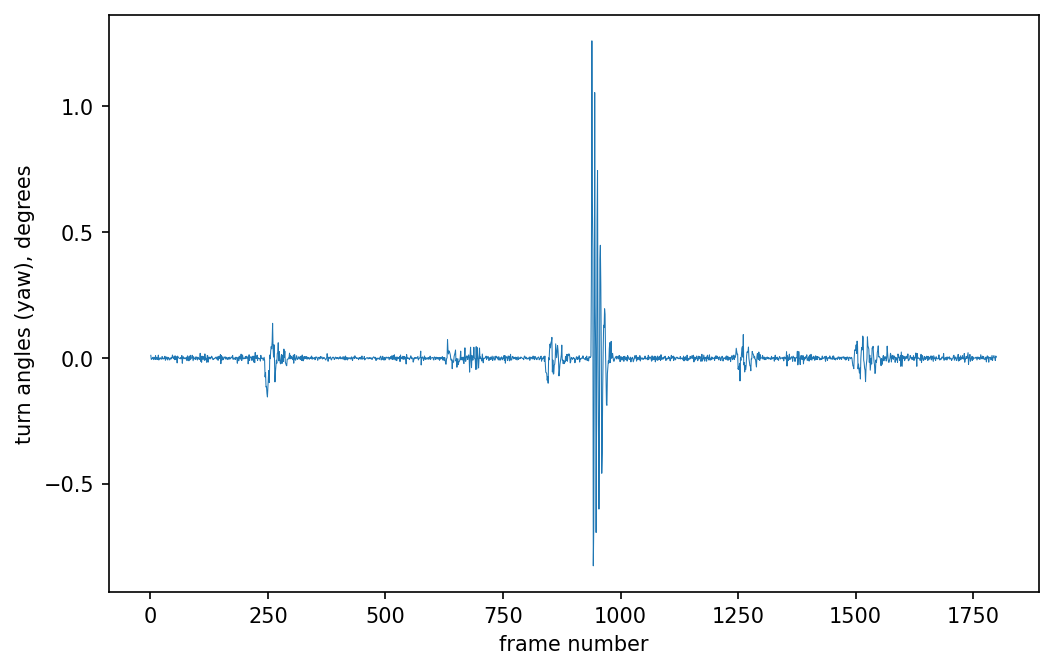

In [27]:
plt.plot(all_metrics[('turn_angles', 'turn_angles')], linewidth=0.5)
plt.ylabel('turn angles (yaw), degrees')
plt.xlabel('frame number')

Text(0.5, 0, 'frame number')

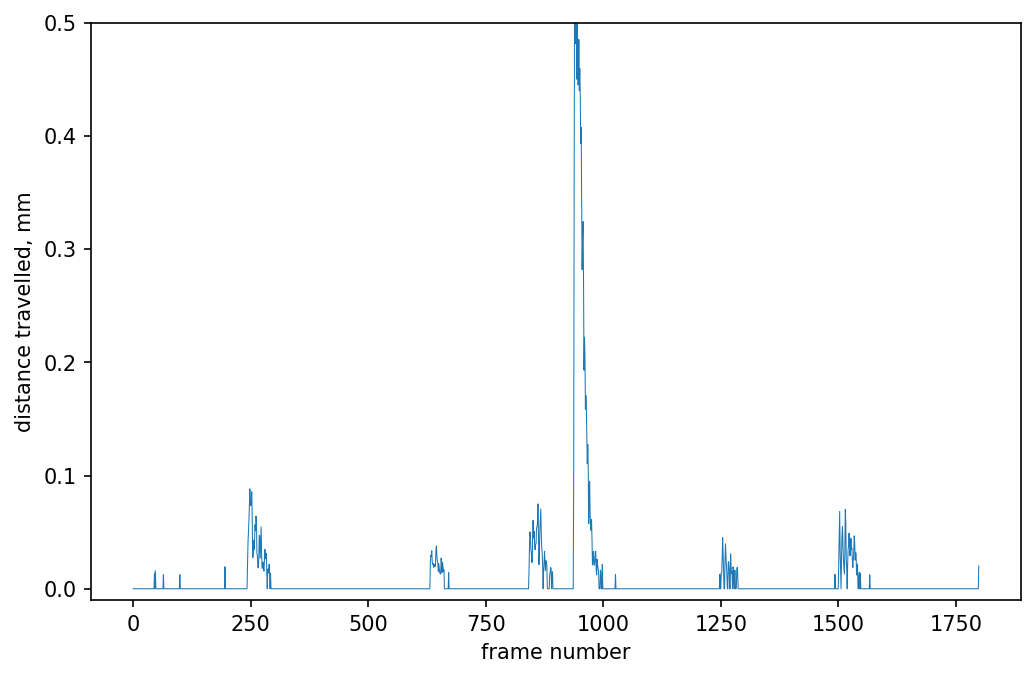

In [28]:
plt.plot(all_metrics[('mean_body_keypoint', 'dist_travelled')], linewidth=0.5)
plt.ylim([-0.01, 0.5])
plt.ylabel('distance travelled, mm')
plt.xlabel('frame number')

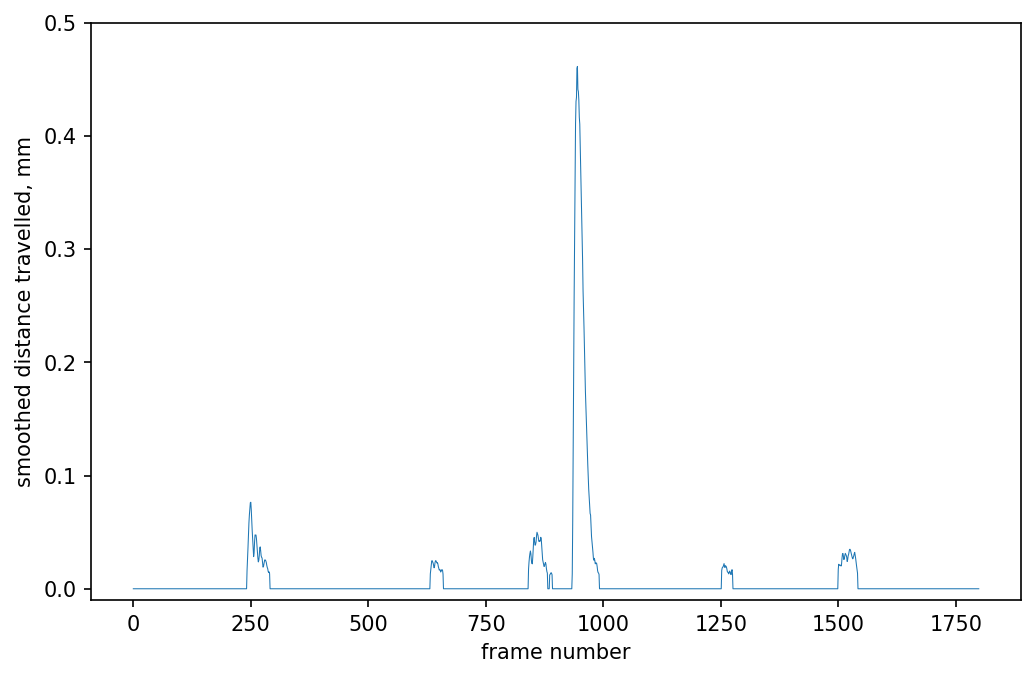

In [29]:
plt.plot(all_metrics[('mean_body_keypoint', 'dist_travelled_smooth')], linewidth=0.5)
plt.ylim([-0.01, 0.5])
plt.ylabel('smoothed distance travelled, mm')
plt.xlabel('frame number')
plt.show()

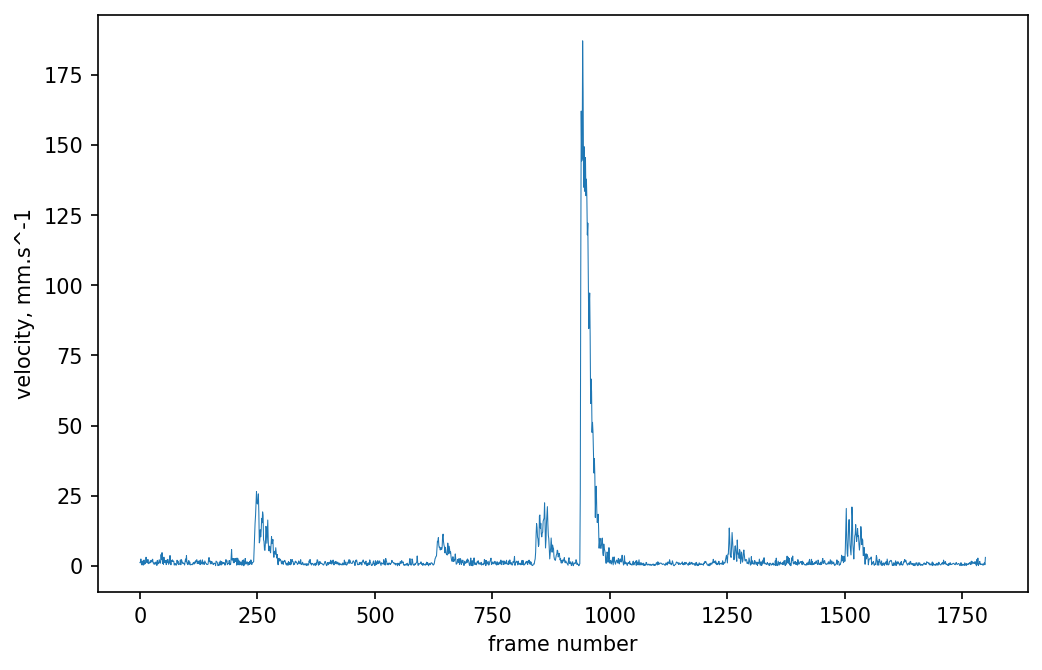

In [30]:
plt.plot(all_metrics[('mean_body_keypoint', 'velocity')], linewidth=0.5)
plt.ylabel('velocity, mm.s^-1')
plt.xlabel('frame number')
plt.show()

In [31]:
all_metrics

Frame      Time heading_degrees heading_vector            \
       Frame      Time heading_degrees              x         y   
0        0.0  0.000000      198.469146       0.949539 -0.313649   
1        1.0  0.003333      198.570620       0.945979 -0.324228   
2        2.0  0.006667      198.596908       0.947521 -0.319695   
3        3.0  0.010000      198.566823       0.948848 -0.315734   
4        4.0  0.013333      198.499173       0.949522 -0.313700   
...      ...       ...             ...            ...       ...   
1795  1795.0  5.983333      246.712224       0.391677 -0.920103   
1796  1796.0  5.986667      246.767416       0.391567 -0.920150   
1797  1797.0  5.990000      246.816593       0.400350 -0.916362   
1798  1798.0  5.993333      246.895688       0.392550 -0.919731   
1799  1799.0  5.996667      247.040635       0.388435 -0.921476   

     mean_body_keypoint                                     \
           acceleration acceleration_smooth dist_to_center   
0             32.721414           42.159411       3.867162   
1            195.296533           77.953080       3.874005   
2            -98.239633           58.426257       3.861052   
3           -316.264527           41.284734       3.857463   
4            146.762405          -44.705987       3.857827   
...                 ...                 ...            ...   
1795          34.978466           10.892614       8.404490   
1796          68.414617           24.331052       8.406179   
1797           0.654526           -4.904629       8.402417   
1798        -108.705308          -14.344983       8.400179   
1799         778.215711           12.826336       8.408858   

                                           ... tail_vector_5 tail_vector_6  \
     dist_to_center_smooth dist_travelled  ...             y             x   
0                 3.865880       0.000000  ...      0.412341     -0.938556   
1                 3.864547       0.000000  ...      0.388454     -0.943641   
2                 3.862830       0.000000  ...      0.395241     -0.942646   
3                 3.860223       0.000000  ...      0.383501     -0.950525   
4                 3.857790       0.000000  ...      0.392407     -0.949291   
...                    ...            ...  ...           ...           ...   
1795              8.403731       0.000000  ...      0.929298     -0.646950   
1796              8.404266       0.000000  ...      0.929646     -0.638256   
1797              8.404800       0.000000  ...      0.931593     -0.647852   
1798              8.405691       0.000000  ...      0.933247     -0.697351   
1799              8.406315       0.020232  ...      0.920193     -0.630331   

               tail_vector_7           tail_vector_8           tail_vector_9  \
             y             x         y             x         y             x   
0     0.345128     -0.953989  0.299841     -0.953492  0.301419     -0.967713   
1     0.330972     -0.957905  0.287085     -0.949003  0.315266     -0.927996   
2     0.333793     -0.957120  0.289690     -0.949990  0.312281     -0.934835   
3     0.310647     -0.957280  0.289162     -0.949483  0.313819     -0.886773   
4     0.314399     -0.959158  0.282872     -0.951576  0.307414     -0.842710   
...        ...           ...       ...           ...       ...           ...   
1795  0.762533     -0.459676  0.888086     -0.405689  0.914011     -0.524238   
1796  0.769824     -0.459370  0.888245     -0.408932  0.912565     -0.529814   
1797  0.761766     -0.459333  0.888264     -0.404260  0.914644     -0.530113   
1798  0.716730     -0.459870  0.887986     -0.386385  0.922338     -0.520785   
1799  0.776326     -0.460716  0.887547     -0.413538  0.910487     -0.515573   

               turn_angles  
             y turn_angles  
0     0.252053         NaN  
1     0.372591    0.011162  
2     0.355082   -0.004788  
3     0.462206   -0.004177  
4     0.538367   -0.002143  
...        ...         ...  
1795  0.851572    0.002140  
1796  0.848

# Try new bout detector (almost the same as the bout detector in matlab)

In [32]:
bouts = bout_detector(all_metrics, frame_rate=300, smooth_window=5, min_peak_separation=0.1667, min_peak_prominence=0.01, num_repeats=7)

Index(['Frame', 'Time', 'heading_degrees', 'heading_vector', 'heading_vector',
       'mean_body_keypoint', 'mean_body_keypoint', 'mean_body_keypoint',
       'mean_body_keypoint', 'mean_body_keypoint', 'mean_body_keypoint',
       'mean_body_keypoint', 'mean_body_keypoint', 'mean_body_keypoint',
       'mean_body_keypoint', 'mean_body_keypoint', 'mean_body_keypoint',
       'mean_body_keypoint', 'mean_body_keypoint', 'mean_body_keypoint',
       'mean_body_keypoint', 'mean_body_keypoint', 'mtc', 'mtc_accel',
       'mtc_velocity', 'origin', 'origin', 'point', 'point', 'tail_angle_1',
       'tail_angle_2', 'tail_angle_3', 'tail_angle_4', 'tail_angle_5',
       'tail_angle_6', 'tail_angle_7', 'tail_angle_8', 'tail_angle_9',
       'tail_vector_1', 'tail_vector_1', 'tail_vector_2', 'tail_vector_2',
       'tail_vector_3', 'tail_vector_3', 'tail_vector_4', 'tail_vector_4',
       'tail_vector_5', 'tail_vector_5', 'tail_vector_6', 'tail_vector_6',
       'tail_vector_7', 'tail_vector_7', 

In [33]:
bouts

{'onset': array([ 238,  627,  837,  932, 1243, 1488], dtype=int64),
 'offset': array([ 314,  673,  912, 1008, 1303, 1578], dtype=int64)}

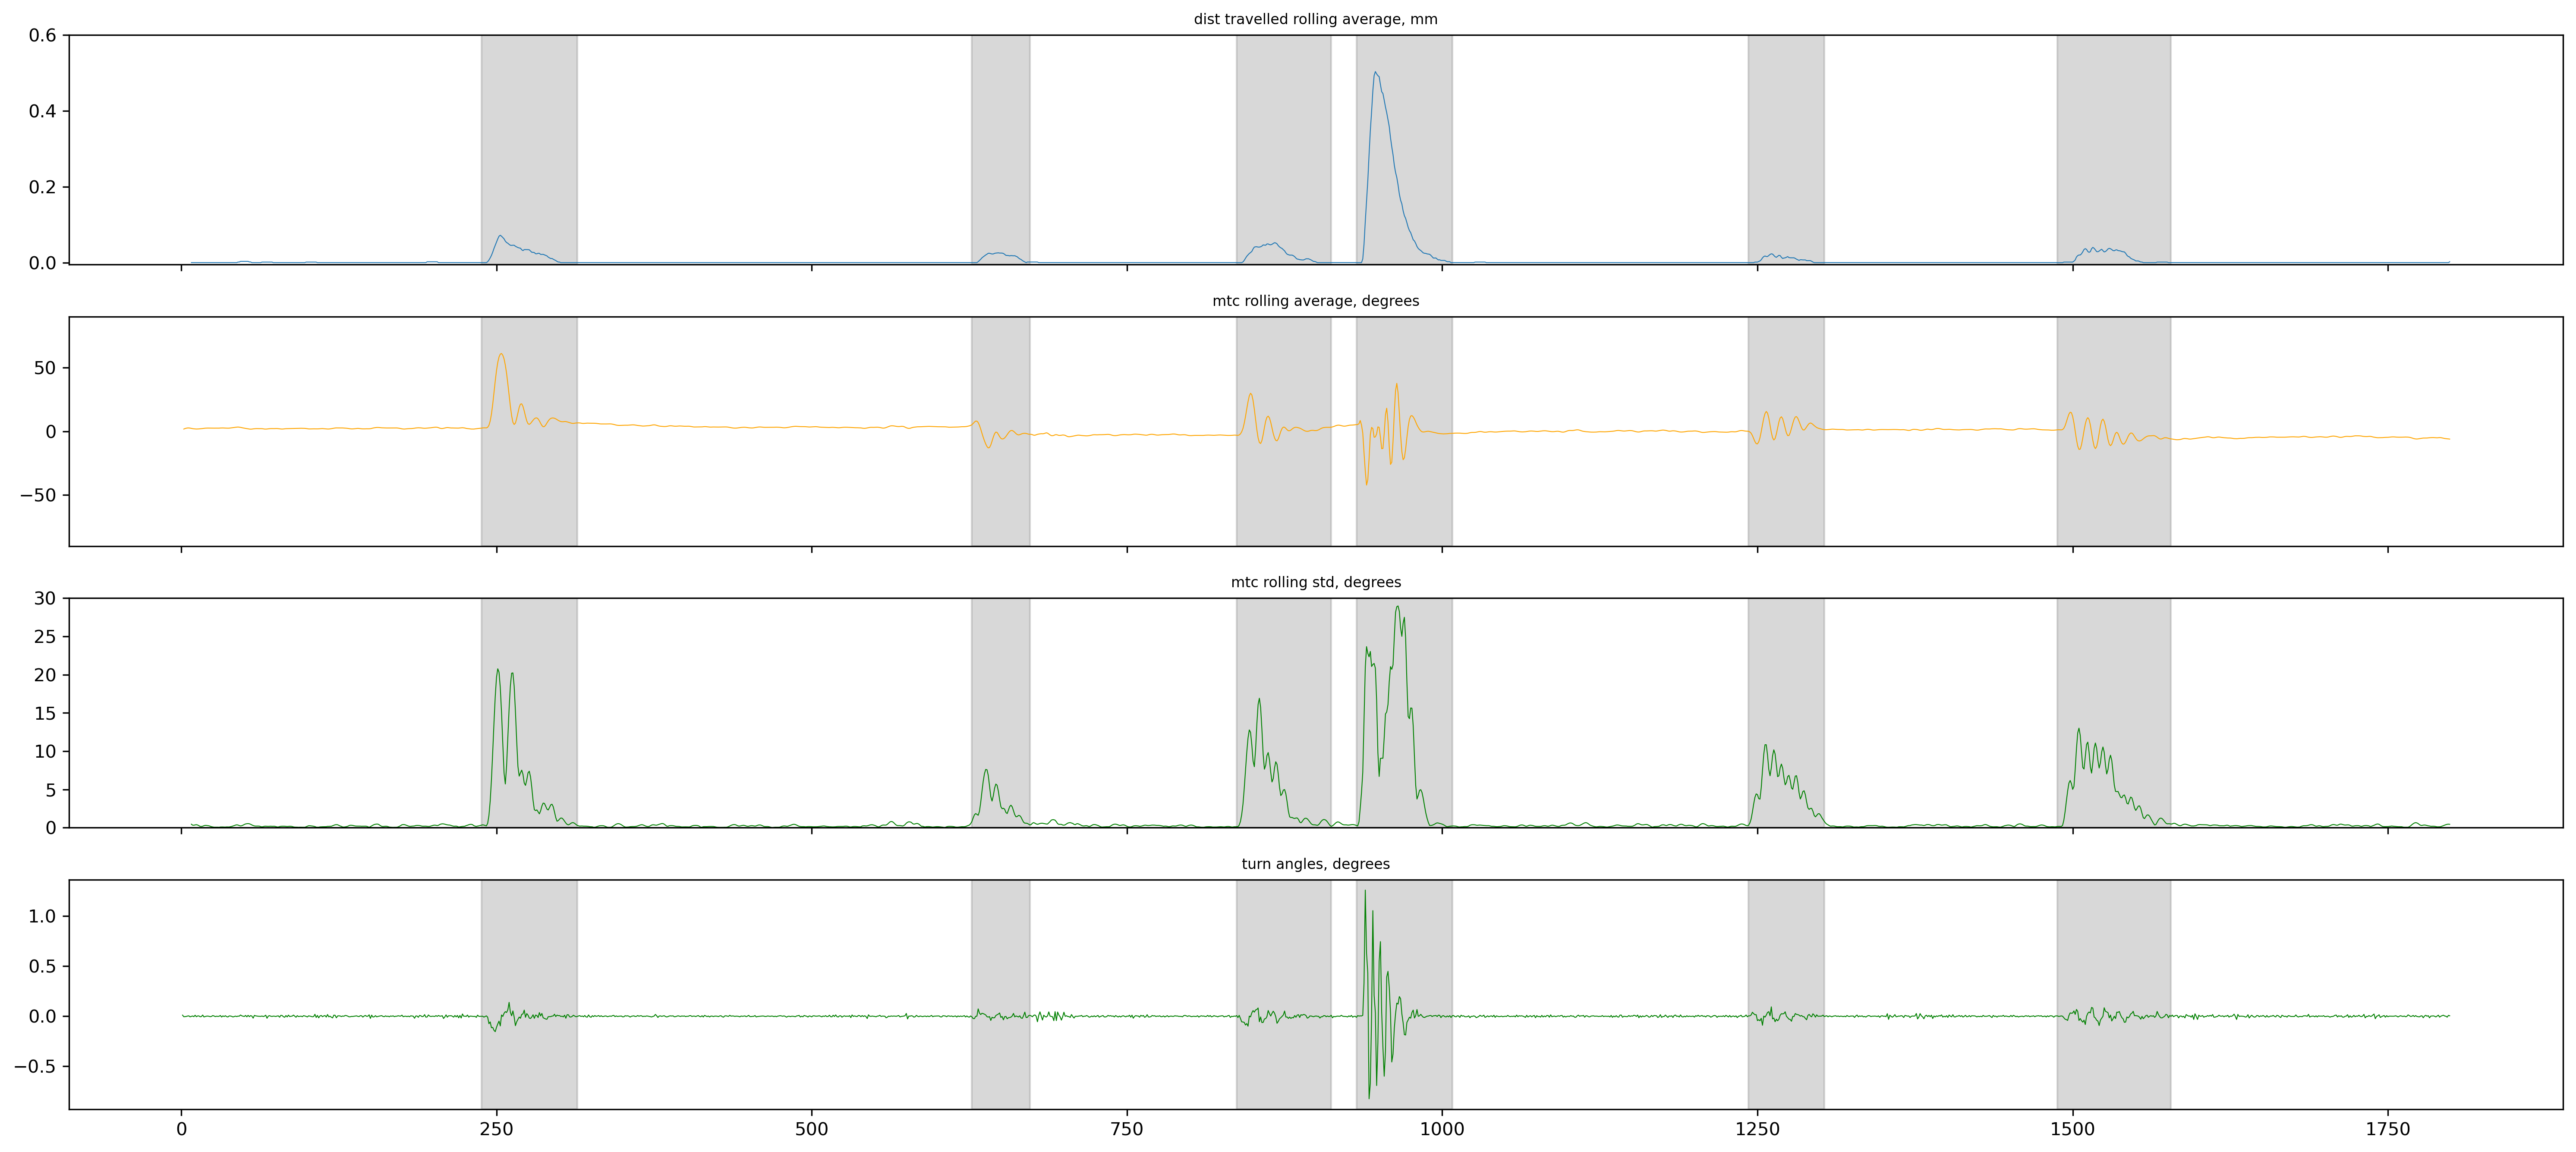

In [34]:
font_properties = {'family':'sans', 'size':8}
fontdict=font_properties
plt.rcParams["figure.figsize"] = (20,9)
plt.rcParams["figure.dpi"] = 300

fig, ax = plt.subplots(4,1,sharex=True)
ax[0].plot(all_metrics[('mean_body_keypoint', 'dist_travelled')].rolling(9).mean(), linewidth=0.5)
ax[1].plot(all_metrics[('mtc', 'mtc')].rolling(3).mean(), linewidth=0.5, c='orange')
ax[2].plot(all_metrics[('mtc', 'mtc')].rolling(9).std(), linewidth=0.5, c='g')
ax[3].plot(all_metrics[('turn_angles', 'turn_angles')], linewidth=0.5, c='g')

# ax[0].set_xlim([0,8000])
ax[0].set_ylim([-0.005,0.6])
ax[1].set_ylim([-90,90])
ax[2].set_ylim([0,30])
ax[0].set_title('dist travelled rolling average, mm', fontdict=font_properties)
ax[1].set_title('mtc rolling average, degrees', fontdict=font_properties)
ax[2].set_title('mtc rolling std, degrees', fontdict=font_properties)
ax[3].set_title('turn angles, degrees', fontdict=font_properties)

# I have two vectors that give when an event starts and when an event ends and I want to highlight these in the plots
# would fill_betweenx() do that? 
#ax[0].fill_betweenx()

for start, end in zip(bouts['onset'], bouts['offset']):
    # Loop through each subplot axis
    for subplot_ax in ax:
        # Draw the vertical span (rectangle)
        subplot_ax.axvspan(
            start, end,          # The x-range to shade
            color='grey',        # The color of the_shade
            alpha=0.3,           # The transparency of the shade
            zorder=0             # Set zorder to 0 to draw behind the plot lines
        )

plt.tight_layout()
plt.show()

# try the function that computes all bout metrics

In [35]:
for bout in [(238,314),(932,1008)]:
    test = compute_single_bout_metrics(all_metrics, onset_offset=bout,
                                       FPS=300,
                                       smooth_point=('mean',30),
                                       smooth_vector=('mean',10),
                                       smooth_vigor_window=44)
    print(test)

{'onset': 238, 'offset': 314, 'onset_s': 0.7933333333333333, 'offset_s': 1.0466666666666666, 'duration': 253.3333333333333, 'total_distance': 1.8212844229609195, 'avg_speed': 7.189280616950999, 'max_speed': 21.63937087684454, 'max_acceleration': 787.9659494587734, 'avg_mtc': 15.56885279462798, 'max_abs_mtc': 61.002792190607884, 'bout_symmetry': 1.0835040405840075, 'max_mtc_velocity': 2737.6073441917156, 'avg_mtc_velocity': 661.8478759161155, 'tailbeat_frequency': 6.0, 'total_vigor': 19309.770733438574, 'max_vigor': 534.946294723017, 'avg_vigor': 283.0556175515232, 'max_turn_angle': 0.13558362918657837, 'bout_end_angle': 41.23472498541358, 'max_tail_amplitude_1': 24.45063377423749, 'max_tail_amplitude_2': 26.210939740028586, 'max_tail_amplitude_3': 43.54357943346629, 'max_tail_amplitude_4': 60.02441511466094, 'max_tail_amplitude_5': 64.00371771782919, 'max_tail_amplitude_6': 76.90706431176179, 'max_tail_amplitude_7': 84.73874279758859, 'max_tail_amplitude_8': 96.63687473858361, 'max_tai

In [36]:
np.array(list(test.values()))

array([ 9.32000000e+02,  1.00800000e+03,  3.10666667e+00,  3.36000000e+00,
        2.53333333e+02,  1.14381665e+01,  4.51506573e+01,  1.51046850e+02,
        5.92761223e+03, -1.21278313e+00,  4.21496679e+01, -5.71071872e-02,
        5.99654618e+03,  1.41631917e+03,  2.90000000e+01,  7.71253544e+04,
        2.67792308e+03,  1.10882381e+03,  7.73195315e-01,  1.18890191e+02,
        1.61388512e+01,  3.20382858e+01,  3.85110229e+01,  5.76791792e+01,
        8.56585622e+01,  1.01841503e+02,  5.92666684e+01,  7.08810741e+01,
        6.81116906e+01], dtype=float64)

In [37]:
test.keys()

dict_keys(['onset', 'offset', 'onset_s', 'offset_s', 'duration', 'total_distance', 'avg_speed', 'max_speed', 'max_acceleration', 'avg_mtc', 'max_abs_mtc', 'bout_symmetry', 'max_mtc_velocity', 'avg_mtc_velocity', 'tailbeat_frequency', 'total_vigor', 'max_vigor', 'avg_vigor', 'max_turn_angle', 'bout_end_angle', 'max_tail_amplitude_1', 'max_tail_amplitude_2', 'max_tail_amplitude_3', 'max_tail_amplitude_4', 'max_tail_amplitude_5', 'max_tail_amplitude_6', 'max_tail_amplitude_7', 'max_tail_amplitude_8', 'max_tail_amplitude_9'])

In [38]:
bouts_dict_test = compute_bout_metrics(bouts,
                                       all_metrics,
                                       FPS=300,
                                       smooth_point=('mean',30),
                                       smooth_vector=('mean',10),
                                       smooth_vigor_window=44,
                                       end_time=6)

[(238, 314), (627, 673), (837, 912), (932, 1008), (1243, 1303), (1488, 1578)]


In [39]:
bouts_df = pd.DataFrame.from_dict(bouts_dict_test)

In [40]:
bouts_df

,onset,offset,onset_s,offset_s,duration,total_distance,avg_speed,max_speed,max_acceleration,avg_mtc,...,max_tail_amplitude_2,max_tail_amplitude_3,max_tail_amplitude_4,max_tail_amplitude_5,max_tail_amplitude_6,max_tail_amplitude_7,max_tail_amplitude_8,max_tail_amplitude_9,IBI,bout_number
0,238,314,0.793333,1.046667,253.333333,1.821284,7.189281,21.639371,787.965949,15.568853,...,26.210940,43.543579,60.024415,64.003718,76.907064,84.738743,96.636875,117.497199,1.296667,1
1,627,673,2.090000,2.243333,153.333333,0.664125,4.331253,7.740762,251.068726,-2.165289,...,9.692624,14.950932,21.008207,21.085188,24.767270,20.918217,29.810212,45.517136,0.700000,2
2,837,912,2.790000,3.040000,250.000000,1.544804,6.179215,15.712239,475.414904,3.278150,...,13.293300,26.022191,20.698255,29.972827,39.790556,41.583172,56.201746,88.370666,0.316667,3
3,932,1008,3.106667,3.360000,253.333333,11.438167,45.150657,151.046850,5927.612226,-1.212783,...,32.038286,38.511023,57.679179,85.658562,101.841503,59.266668,70.881074,68.111691,1.036667,4
4,1243,1303,4.143333,4.343333,200.000000,0.522067,2.610334,7.680379,327.239029,2.781650,...,12.356529,12.578822,21.431419,26.894053,27.556576,28.234072,36.388800,54.312824,0.816667,5
5,1488,1578,4.960000,5.260000,300.000000,1.359111,4.530369,12.047047,461.647174,-2.454882,...,20.485042,18.819363,33.718768,29.343254,27.480868,32.085885,37.256443,47.132865,1.040000,6
